In [1]:
import os
import time
from copy import deepcopy
from collections import OrderedDict
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from hdf5storage import loadmat, savemat

import pycochleagram.cochleagram as cgram

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.clear_param_store()

from tools.experiment_neural import stim_tr, stim_vl, data_tr, data_vl, stim_tx, data_tx
from tools.data_librispeech import LibriDataset, load_subset, cgram_params
from tools.nsr_utils import train_nsr, validate_nsr, Experiment

cuda = torch.cuda.is_available() and False
print("cuda" if cuda else "cpu")

cpu


In [3]:
window = 20
dilation = 1
downsample = 8

X = [torch.from_numpy(x)[:,:] for x in stim_tr]
X = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X]
X = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X]
Y = [torch.from_numpy(y[:,:]) for y in data_tr]
print(X[0].shape, Y[0].shape, round(sp.stats.pearsonr(X[0].mean(-1), Y[0][:,29])[0], 3))

X_test = [torch.from_numpy(x) for x in stim_vl]
X_test = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X_test]
X_test = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X_test]
Y_test = [torch.from_numpy(y[:,:,:].mean(-1)) for y in data_vl]
print(X_test[0].shape, Y_test[0].shape, round(sp.stats.pearsonr(X_test[0].mean(-1), Y_test[0][:,29])[0], 3))

# eps = 2
# min_y = min(min(torch.cat(Y)), min(torch.cat(Y_test)))
# Y = [y+min_y+eps for y in Y]
# Y_test = [y+min_y+eps for y in Y_test]

num_frames = len(X)
xdim = X[0].shape[-1]
ydim = Y[0].shape[-1] if Y[0].ndim > 1 else 1

dt = 1e-2
print(f'{sum([len(x) for x in X])*dt/60:.2f} minutes')
print(f'{sum([len(x) for x in X_test])*dt:.2f} seconds')
# plt.plot(X[0])
# plt.plot(Y[0])
# plt.show()

torch.Size([6097, 160]) torch.Size([6097, 404]) 0.507
torch.Size([500, 160]) torch.Size([500, 404]) 0.544
29.98 minutes
40.00 seconds


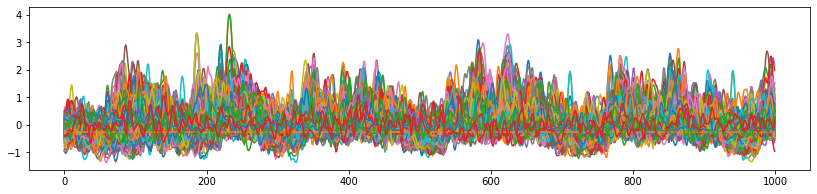

In [4]:
U = torch.cat(X[:])[:6000]
Z = torch.cat(Y[:])[:6000]

udim, zdim = U.shape[-1], Z.shape[-1]

plt.figure(figsize=(14,3))
plt.plot(U[:1000,:])
plt.plot(Z[:1000,:]);
# plt.legend([f'{i}' for i in range(21)]);

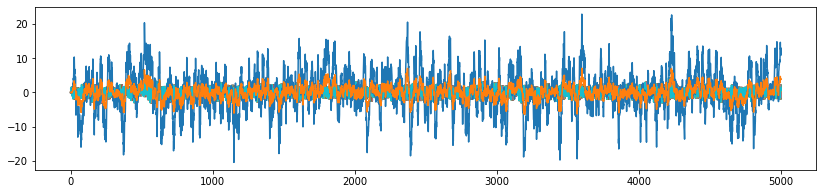

In [2]:
U = torch.randn(5000,1)
U = F.unfold(F.pad(U, (0,0,19,0)).T.unsqueeze(0).unsqueeze(-1), (20,1)).squeeze(0).squeeze(-1).T
X = [torch.zeros(1)]
Z = [torch.zeros(2)]

for i in range(1,len(U)):
    a = 0.87 + 0.05*torch.randn(1)
    b = 1.25 + 0.05*torch.randn(1)
    c = 0.47 + 0.15*torch.randn(1)
    d = 1.91 + 0.10*torch.randn(1)
    e = 0.63 + 0.05*torch.randn(1)
    
    X += [a*X[i-1] + b*U[i,0:1] + c*U[i,7:8] + 5e-2*torch.randn(1)]
    Z += [torch.cat((d*X[i] + 5e-2*torch.randn(1), e*X[i] + 5e-2*torch.randn(1)))]
X = torch.stack(X)
Z = torch.stack(Z)

udim, zdim = U.shape[-1], Z.shape[-1]

plt.figure(figsize=(14,3))
plt.plot(U)
plt.plot(Z);

(tensor(0.4945), tensor(2.9758))

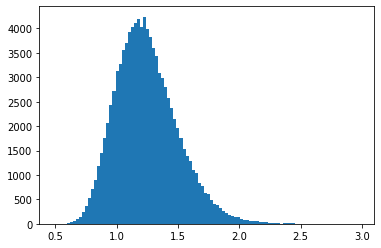

In [537]:
q = dist.LogNormal(0.2, 0.2)
q = torch.tensor([q.rsample() for _ in range(100_000)])
plt.hist(q, bins=100);
q.min(), q.max()

In [28]:
def kalman_filter(udim, xdim, zdim, cuda=False):
    device = "cuda" if cuda else "cpu"
    
    def model(u, z):
        u, z = u.to(device), z.to(device)
        # a HalfNormal or HalfCauchy can be used here
        Q = 0.1*torch.ones(xdim, device=device)
        R = 0.1*torch.ones(zdim, device=device)
        
        # State transition matrix
        con1, con0 = torch.tensor(2.5, device=device), torch.tensor(2.5, device=device)
        with pyro.plate("plate_F", xdim):
            F = pyro.sample("state_transition", dist.Beta(con1, con0))
        F = torch.diag(F)
        
        # External input transition matrix
        with pyro.plate("plate_G", xdim*udim):
            G = pyro.sample("input_transition", dist.Normal(
                    torch.zeros(1,device=device), 0.1*torch.ones(1,device=device)))
        G = G.reshape(xdim,udim)
        
        # Measurement transition matrix
        with pyro.plate("plate_measurement", zdim*xdim):
            H = pyro.sample("measurement_transition", dist.HalfNormal(
                    1.0*torch.ones(1,device=device)))
        H = H.reshape(zdim,xdim)
        
        # Measurement bias
        with pyro.plate("plate_bias", zdim):
            bias = pyro.sample("measurement_bias", dist.Normal(
                    torch.zeros(1,device=device), 0.2*torch.ones(1,device=device)))
        
        # Prepare time series variables
        time_steps = len(u)
        X, Z = [], []

        # Initialize state
        X0 = torch.zeros(xdim, device=device)

        for t in range(time_steps):
            # Predict next step
            with pyro.plate(f'plate_state_{t}', xdim):
                X += [pyro.sample(f'state_{t}',
                                  dist.Normal(G @ u[t,:] + F @ (X0 if t==0 else X[t-1]), Q))]
            
            # Measure
            with pyro.plate(f'measurement_{t}', zdim):
                Z += [pyro.sample(f'obs_{t}',
                                  dist.Normal(H @ X[t] + bias, R), obs=z[t,:])]
    
    guide = pyro.infer.autoguide.AutoDelta(
        pyro.poutine.block(model, expose=["state_transition", "input_transition",
                                          "measurement_transition", "measurement_bias"]))
    
    return model, guide

## LDS

In [29]:
ldim = 1
model, guide = kalman_filter(udim, ldim, zdim, cuda=False)
optim = pyro.optim.Adam({'lr': 1e-1})
# optim = pyro.optim.SGD({'lr': 1e-5, 'momentum': 0.1})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

num_iterations, interval = 500, 1

# def train(num_iterations, interval=50):
loss_tr = []
corr_tr, corr_vl = [], []
pyro.clear_param_store()
#model.set_constraints()

for j in range(num_iterations):
    t0 = time.clock_gettime(0)
    with torch.autograd.set_detect_anomaly(True):
        loss = svi.step(U, Z)
    epoch_time = time.clock_gettime(0) - t0
    loss_tr.append(loss/len(U))
    
    if j % interval == 0:
        t = time.localtime()
        t = f'{t.tm_year}/{t.tm_mon:02d}/{t.tm_mday:02d}-{t.tm_hour:02d}:{t.tm_min:02d}'
        print(f'{t} -- [iteration {j+1:04d}] loss: {loss_tr[-1]:.4f} -- epoch time: {epoch_time:.3f} sec')

# return loss_tr

# history = train(200, 10)

2019/11/13-02:40 -- [iteration 0001] loss: 2094.4247 -- epoch time: 31.080 sec
2019/11/13-02:40 -- [iteration 0002] loss: 1938.0727 -- epoch time: 29.622 sec
2019/11/13-02:41 -- [iteration 0003] loss: 1778.9569 -- epoch time: 29.487 sec
2019/11/13-02:41 -- [iteration 0004] loss: 1643.9650 -- epoch time: 29.413 sec
2019/11/13-02:42 -- [iteration 0005] loss: 1520.1392 -- epoch time: 29.610 sec
2019/11/13-02:42 -- [iteration 0006] loss: 1402.0699 -- epoch time: 29.403 sec
2019/11/13-02:43 -- [iteration 0007] loss: 1281.3971 -- epoch time: 29.633 sec
2019/11/13-02:43 -- [iteration 0008] loss: 1159.6168 -- epoch time: 29.296 sec
2019/11/13-02:44 -- [iteration 0009] loss: 1036.7383 -- epoch time: 29.886 sec
2019/11/13-02:44 -- [iteration 0010] loss: 910.2936 -- epoch time: 29.182 sec
2019/11/13-02:45 -- [iteration 0011] loss: 783.7950 -- epoch time: 29.904 sec
2019/11/13-02:45 -- [iteration 0012] loss: 659.1509 -- epoch time: 29.136 sec
2019/11/13-02:46 -- [iteration 0013] loss: 565.7827 -- 

KeyboardInterrupt: 

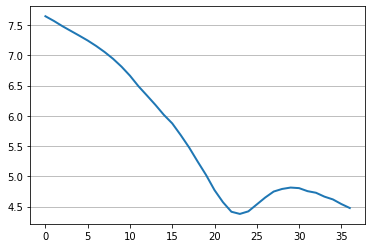

In [30]:
history = loss_tr
plt.plot(np.log(history), linewidth=2)
plt.grid(axis='y')
plt.show()

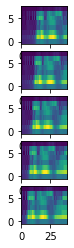

In [601]:
plt.subplot(511)
plt.imshow(U[85,:].reshape(8,40), aspect=4, origin='ll');
plt.subplot(512)
plt.imshow(U[87,:].reshape(8,40), aspect=4, origin='ll');
plt.subplot(513)
plt.imshow(U[89,:].reshape(8,40), aspect=4, origin='ll');
plt.subplot(514)
plt.imshow(U[91,:].reshape(8,40), aspect=4, origin='ll');
plt.subplot(515)
plt.imshow(U[93,:].reshape(8,40), aspect=4, origin='ll');

In [31]:
params = pyro.get_param_store()
F = params["auto_state_transition"]
G = params["auto_input_transition"]
H = params["auto_measurement_transition"]
B = params["auto_measurement_bias"]

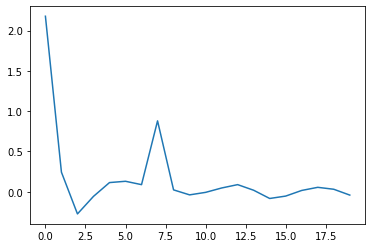

In [33]:
plt.plot(G.reshape(20,1).detach())

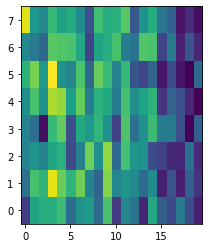

In [38]:
plt.imshow(G.reshape(20,8).detach().T, aspect=3, origin='ll')

In [ ]:
params = pyro.get_param_store()
X_latent = torch.cat([params[f'auto_state_{i}'] for i in range(600)]).detach()
C_input = torch.tensor([sp.stats.pearsonr(X_latent[:,0], U[:,i])[0] for i in range(udim)])
C_inmean = torch.tensor([sp.stats.pearsonr(X_latent[:,0], U.mean(1))[0] for i in range(udim)])
C_output = torch.tensor([sp.stats.pearsonr(X_latent[:,0], Z[:,i])[0] for i in range(udim)])
C_outmean = torch.tensor([sp.stats.pearsonr(X_latent[:,0], Z.mean(1))[0] for i in range(udim)])
C_inout = torch.tensor([sp.stats.pearsonr(U.mean(1), Z[:,i])[0] for i in range(udim)])

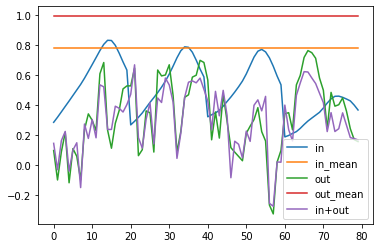

In [256]:
plt.plot(C_input)
plt.plot(C_inmean)
plt.plot(C_output)
plt.plot(C_outmean)
plt.plot(C_inout)
plt.legend(['in','in_mean','out','out_mean','in+out'])
plt.show()

In [19]:
params = pyro.get_param_store()
G = params['auto_input_transition'].detach().reshape(32,udim)
H = params['auto_measurement_transition'].detach().reshape(zdim,32)
G.shape, H.shape

(torch.Size([32, 160]), torch.Size([404, 32]))

In [20]:
x0 = torch.zeros(32)
x, z = [], []
for t in range(6000):
    x += [G @ U[t,:]]
    z += [H @ x[t]]
x, z = torch.stack(x), torch.stack(z)
x.shape, z.shape

(torch.Size([6000, 32]), torch.Size([6000, 404]))

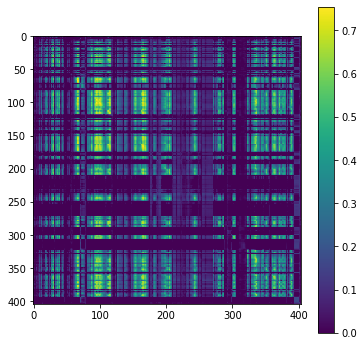

In [21]:
Q = torch.zeros(zdim,zdim)
for i in range(zdim):
    for j in range(zdim):
        Q[i,j] = sp.stats.pearsonr(z[:,i], Z[:,j])[0]

plt.figure(figsize=(6,6))
plt.imshow(torch.clamp_min(Q,0), aspect=1)
plt.colorbar()
plt.show()

Q0 = Q

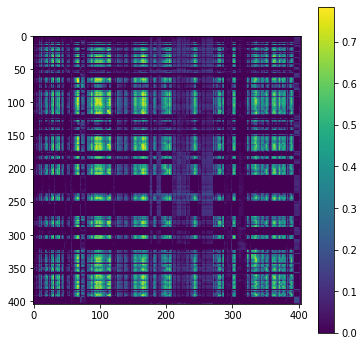

In [578]:
Q = torch.zeros(zdim,zdim)
for i in range(zdim):
    for j in range(zdim):
        Q[i,j] = sp.stats.pearsonr(z[:,i], Z[:,j])[0]

plt.figure(figsize=(6,6))
plt.imshow(torch.clamp_min(Q,0), aspect=1)
plt.colorbar()
plt.show()

Q0 = Q

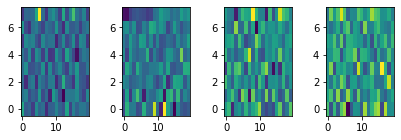

In [565]:
G = params['auto_input_transition'].detach().reshape(32,8,20)
plt.figure(figsize=(7,2))
plt.subplot(141); plt.imshow(G[0], aspect=4, origin='ll')
plt.subplot(142); plt.imshow(G[1], aspect=4, origin='ll')
plt.subplot(143); plt.imshow(G[2], aspect=4, origin='ll')
plt.subplot(144); plt.imshow(G[3], aspect=4, origin='ll');

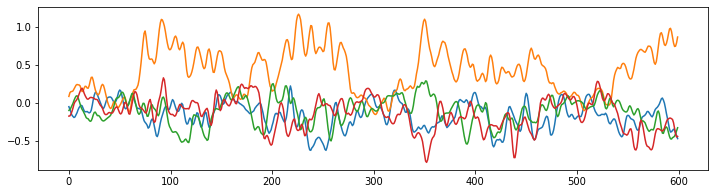

In [577]:
plt.figure(figsize=(12,3))
plt.plot(torch.cat([params[f'auto_state_{i}'] for i in range(600)]).detach().reshape(-1,32));

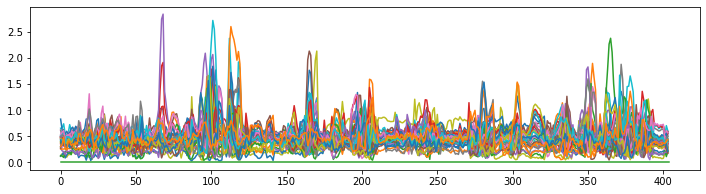

In [567]:
params = pyro.get_param_store()
filt = params['auto_measurement_transition'].detach().reshape(-1,32)
plt.figure(figsize=(12,3))
plt.plot(filt); plt.plot([0,zdim],[0,0]);
# plt.figure(figsize=(4,2)); plt.imshow(filt.reshape(zdim,1), aspect=4, origin='ll');
# plt.colorbar();

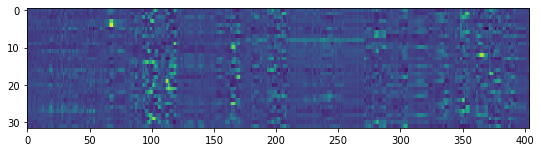

In [575]:
plt.figure(figsize=(9,4))
plt.imshow(sp.stats.zscore(filt).T, aspect=3);

In [576]:
params = pyro.get_param_store()
params['auto_state_transition'].detach()

tensor([0.8694, 0.8516, 0.8983, 0.9204, 0.8701, 0.7857, 0.9331, 0.8201, 0.9667,
        0.8175, 0.9415, 0.8834, 0.9226, 0.8121, 0.9508, 0.8211, 0.8118, 0.8215,
        0.8312, 0.8371, 0.8134, 0.9232, 0.9030, 0.8545, 0.8424, 0.9312, 0.8391,
        0.9183, 0.9231, 0.8548, 0.8825, 0.8794])

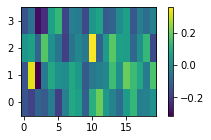

In [230]:
params = pyro.get_param_store()
filt = params['auto_input_transition'].detach()
# plt.plot(filt);
plt.figure(figsize=(4,2)); plt.imshow(filt.reshape(udim//window,window), aspect=4, origin='ll');
plt.colorbar();

In [ ]:
plt.plot([sp.stats.pearsonr(Z.flatten(), U[:,i])[0] for i in range(udim)])
plt.plot([sp.stats.pearsonr(Z.flatten(), U @ filt)[0] for i in range(udim)])
plt.xticks(range(0,udim,5),range(1,udim+1,5))
plt.grid(axis='x')
plt.show()

In [ ]:
params['auto_loc'][0].item(), params['auto_scale'][0].item()

In [ ]:
plt.figure(figsize=(5,6))
plt.subplot(211)
plt.plot(params['auto_loc'][1:21].detach())
plt.subplot(212)
plt.plot(params['auto_scale'][1:21].detach());

In [ ]:
params = pyro.get_param_store()
print('F:', [_.item() for _ in params['auto_state_transition']])
print('G:', [_.item() for _ in params['auto_input_transition']])
print('H:', [_.item() for _ in params['auto_measurement_transition']])

In [ ]:
S = np.array([pyro.get_param_store()[f'auto_state_{_}'].item() for _ in range(500)])
plt.plot(S)
plt.plot(Z[0]/3);

sp.stats.pearsonr(S, Z[0].flatten().numpy())

In [186]:
for name, value in pyro.get_param_store().items():
    if not name.startswith('auto_state_'):
        print(name, pyro.param(name).shape)

auto_F_loc torch.Size([1, 1])
auto_G_loc torch.Size([1])
auto_input_transition torch.Size([1])
auto_H_loc torch.Size([1])
auto_measurement_transition torch.Size([1])
auto_X_init torch.Size([1, 1])


In [236]:
minmax = lambda name: print(f'{name}: {min(pyro.get_param_store()[name]).item():.3f}, {max(pyro.get_param_store()[name]).item():.3f}')

minmax('auto_F_loc')
minmax('auto_G_loc')
minmax('auto_H_loc')
minmax('auto_X_init')
minmax('auto_input_transition')
minmax('auto_measurement_transition')

auto_F_loc: 0.575, 0.575
auto_G_loc: 0.057, 0.057
auto_H_loc: 0.149, 0.149
auto_X_init: 0.078, 0.078
auto_input_transition: 0.317, 0.317
auto_measurement_transition: 2.855, 2.855


In [ ]:
plt.plot(history[0])
plt.plot(history[1])
plt.legend(('true','estimate'), fontsize=12)
plt.show()

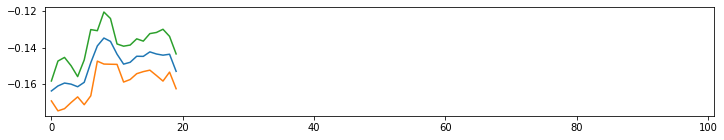

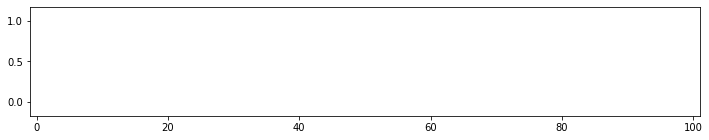

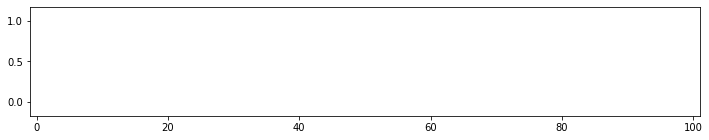

In [245]:
loc = pyro.param('kernel_loc').detach().cpu()
scale = pyro.param('kernel_scale').detach().cpu()
for i in range(3):
    plt.figure(figsize=(12,2))
    plt.plot(loc[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]-scale[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]+scale[i*100:(i+1)*100])
    plt.xlim(-1,101)
    plt.show()

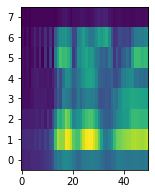

In [206]:
plt.figure(figsize=(3,3))
plt.imshow(X[0][95,:].reshape(-1,window), aspect=8, origin='ll')
plt.show()

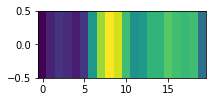

In [246]:
plt.figure(figsize=(3,3))
plt.imshow(pyro.param('kernel_loc').reshape(-1,window).detach().cpu(), aspect=8, origin='ll')
plt.show()

In [247]:
pyro.param('kernel_loc').detach(), pyro.param('memory_loc').detach(), pyro.param('readout_loc').detach()

(tensor([-0.1637, -0.1609, -0.1593, -0.1599, -0.1614, -0.1590, -0.1482, -0.1390,
         -0.1347, -0.1366, -0.1436, -0.1490, -0.1480, -0.1447, -0.1448, -0.1423,
         -0.1435, -0.1441, -0.1436, -0.1529]),
 tensor([0.3259]),
 tensor([0.2483]))

(-0.494118617229904, 3.860443390875746e-32)

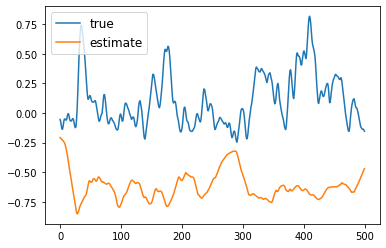

In [248]:
x, y = X_test[1], Y_test[1]
z = model.filter(x)
z = z.detach().cpu()
plt.plot(y[:500])
plt.plot(z[:500])
plt.legend(('true','estimate'), fontsize=12)
sp.stats.pearsonr(y, z)

In [ ]:
# from pyro.contrib.tracking.extended_kalman_filter import EKFState
# from pyro.contrib.tracking.distributions import EKFDistribution
# from pyro.contrib.tracking.dynamic_models import NcvContinuous
# from pyro.contrib.tracking.measurements import PositionMeasurement


# def model(x, y):
#     weight_x1 = pyro.sample('weight_x1', dist.Normal(0, 1))
#     weight_x2 = pyro.sample('weight_x2', dist.Normal(0, 1))
#     bias = pyro.sample('bias', dist.Normal(5, 1))
    
#     with pyro.plate('observations'):
#         target = pyro.sample('obs', dist.Normal(x[:, 0] * weight_x1 + x[:, 1] * weight_x2 + bias, 1), obs=y)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
# optim = pyro.optim.Adam({"lr": 0.005})
# svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=1000)

# def train(num_iterations):
#     pyro.clear_param_store()
#     for j in range(num_iterations):
#         loss = svi.step(x, y)
#         if j % 500 == 0:
#             print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))

# train(5000)


# for name, value in pyro.get_param_store().items():
#     print(name, pyro.param(name))

In [ ]:
# Continuous model
ncv = NcvContinuous(dim, 2.0)

# Truth trajectory
xs_truth = torch.zeros(num_frames, dim)
xs_truth[:,:1] = X

In [ ]:
# # Measurements
# measurements = []
# mean = torch.zeros(2)
# # no correlations
# cov = 1e-5 * torch.eye(2)
# with torch.no_grad():
#     # sample independent measurement noise
#     dzs = pyro.sample('dzs', dist.MultivariateNormal(mean, cov).expand((num_frames,)))
#     # compute measurement means
#     zs = xs_truth[:, :2] + dzs

# Measurements
# zs = torch.cat((X, y), 1)
zs = y

In [ ]:
def model(data):
    # a HalfNormal can be used here as well
    R = pyro.sample('pv_cov', dist.HalfCauchy(2e-6)) * torch.eye(2)
    Q = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(1)
    # observe the measurements
    pyro.sample('track_{}'.format(i), EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames), obs=data)

guide = pyro.infer.autoguide.AutoDelta(model)  # MAP estimation

In [ ]:
optim = pyro.optim.Adam({'lr': 2e-1})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(retain_graph=True))

# pyro.set_rng_seed(0)
pyro.clear_param_store()

for i in range(250):
    loss = svi.step(zs)
    if not i % 10:
        print('loss: ', loss)

In [ ]:
# retrieve states for visualization
R = guide()['pv_cov'] * torch.eye(2)
Q = guide()['measurement_cov'] * torch.eye(1)
ekf_dist = EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames)
states = ekf_dist.filter_states(zs)

In [ ]:
list(ncv.parameters())

In [ ]:
S = np.stack([_.mean.detach().cpu().numpy() for _ in states])
S.shape

In [ ]:
plt.plot(S);

In [ ]:
np.corrcoef(S.T)[0,1]

In [87]:
# class KalmanFilter(nn.Module):
#     def __init__(self, udim, xdim, zdim):
#         super().__init__()
#         self.udim = udim
#         self.xdim = xdim
#         self.zdim = zdim
    
#     def forward(self, u, z):
#         # a HalfNormal can be used here as well
#         Q = pyro.sample('state_cov', dist.HalfCauchy(2e-6)) * torch.eye(self.xdim)
#         R = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(self.zdim)
        
#         # State transition matrix
#         F_loc = pyro.sample('F_loc', dist.MultivariateNormal(torch.zeros(self.xdim*self.xdim), torch.eye(self.xdim*self.xdim)))
#         F_scale = pyro.sample('F_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.xdim*self.xdim)
#         F = pyro.sample('state_transition', dist.MultivariateNormal(F_loc, F_scale)).reshape(self.xdim,self.xdim)
        
#         # External input transition matrix
#         G_loc = pyro.sample('G_loc', dist.MultivariateNormal(torch.zeros(self.xdim*self.udim), torch.eye(self.xdim*self.udim)))
#         G_scale = pyro.sample('G_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.xdim*self.udim)
#         G = pyro.sample('input_transition', dist.MultivariateNormal(G_loc, G_scale)).reshape(self.xdim,self.udim)
        
#         # Measurement transition matrix
#         H_loc = pyro.sample('H_loc', dist.MultivariateNormal(torch.zeros(self.zdim*self.xdim), torch.eye(self.zdim*self.xdim)))
#         H_scale = pyro.sample('H_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.zdim*self.xdim)
#         H = pyro.sample('measurement_transition', dist.MultivariateNormal(H_loc, H_scale)).reshape(self.zdim,self.xdim)
        
#         # Prepare time series variables
#         time_steps = len(u)
#         X = torch.zeros(time_steps, self.xdim)
#         P = torch.zeros(time_steps, self.xdim, self.xdim)
#         Z = torch.zeros(time_steps, self.zdim)
        
#         # Initialize state
#         X0 = pyro.sample('X_init', dist.Normal(torch.zeros(self.xdim), torch.eye(self.xdim)))
#         P0 = pyro.sample('P_init', dist.HalfCauchy(2e-6)) * torch.eye(self.xdim)
        
#         for t in range(time_steps):
#             # Predict next step
#             if t == 0:
#                 X[t,:] = pyro.sample(f'state_{t}', dist.Normal(F @ X0 + G @ u[t,:], Q))
#                 P[t,:,:] = F @ P0 @ F.transpose(-1,-2) + Q
#             else:
#                 X[t,:] = pyro.sample(f'state_{t}', dist.Normal(F @ X[t-1,:] + G @ u[t,:], Q))
#                 P[t,:,:] = F @ P[t-1,:,:] @ F.transpose(-1,-2) + Q
            
#             # Calculate Kalman gain
#             S = H @ P[t,:,:] @ H.transpose(-1,-2) + R
#             #K = P[t,:,:] @ H.transpose(-1,-2) @ S^-1
#             K_prefix = P[t,:,:] @ H.transpose(-1,-2)
            
#             # Measurement torch.solve()[0]
#             Z[t,:] = pyro.sample(f'obs_{t}', dist.Normal(H @ X[t,:], R), obs=z[t,:])
            
#             # Adjust by measurement
#             #P[t,:] = (torch.eye(self.xdim) - K @ H) @ P[t,:]
#             P[t,:] = (torch.eye(self.xdim) - K_prefix @ torch.solve(H, S)[0]) @ P[t,:]
#             #X[t,:] = X[t,:] + K @ (z[t,:] - H @ X[t,:])
#             X[t,:] = X[t,:] + (K_prefix @ torch.solve((z[t,:] - H @ X[t,:]).unsqueeze(1), S)[0]).squeeze(1)
    
#     def guide(self):
#         return pyro.infer.autoguide.AutoDelta(self.forward)
    
#     def filter(self, x):
#         raise NotImplementedError("Forward filtering not yet implemented!")